In [1]:
from time import time
import matplotlib.pyplot as plt
from sksparse.cholmod import cholesky
import scipy
import scipy.sparse.linalg
import numpy as np

In [2]:
nsides = [4, 8, 16, 32] 
nside = 4
A = scipy.sparse.load_npz('deepsphere/matrices/{}_stiffness.npz'.format(nside))
B = scipy.sparse.load_npz('deepsphere/matrices/{}_mass.npz'.format(nside))
npix = A.shape[0]

# 1) Sparse Cholesky Decomposition

### 1.1) Measuring the time to decompose the matrix B

In [3]:
t = time()
factor = cholesky(B)
print("Seconds to perform a sparse Cholesky decomposition = ", time()-t)

Seconds to perform a sparse Cholesky decomposition =  0.00339508056640625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  


Let's visualize the result of the sparse Cholesky decomposition:

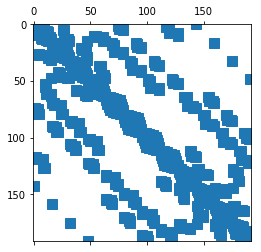

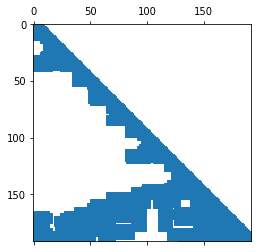

In [4]:
plt.spy(A)
plt.show()
plt.spy(factor.L())

In [5]:
#scipy.sparse.save_npz('matrices/{}_cholB'.format(nside), factor.L())

### 1.2) Measuring the time to solve the two sparse triangular systems

In [6]:
b = np.ones(npix)
t = time()
x0 = factor.solve_A(A@b)
print(time()-t)

0.0007174015045166016


# 2) Naive solution of the system

In [7]:
B_array = B.toarray()
A_array = A.toarray()
t = time()
x1 = np.linalg.solve(B_array,A_array@b)
naive_time = time()-t
print(naive_time)

0.007051944732666016


The solutions obtained with the two methods are actually almost the same:

In [8]:
np.linalg.norm(x0-x1)

1.2710090109837665e-13

# 3) Tensorflow implementation (full Cholesky decomposition)

In [9]:
import tensorflow as tf;

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:472: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:473: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:474: FutureWarning: Passing (type, 1) or 

In [10]:
RHS = np.random.rand(npix,1) 
t = time()
chol = tf.cholesky(B_array)  # shape 10 x 2 x 2
print(time()-t)

0.05523228645324707


In [11]:
chol

<tf.Tensor 'Cholesky:0' shape=(192, 192) dtype=float64>

In [12]:
t = time()
X = tf.cholesky_solve(tf.constant([chol]), RHS)
print(time()-t)
# tf.matmul(A, X) ~ RHS
X  # Solution to the linear system A x = RHS

TypeError: List of Tensors when single Tensor expected

In [ ]:
naive_line = []
tf_line = []
nsides = [4, 8, 16, 32] # cannot do larger, as this results in too big a tensor (>2GB)

for nside in nsides:
    A = scipy.sparse.load_npz('deepsphere/matrices/{}_stiffness.npz'.format(nside))
    B = scipy.sparse.load_npz('deepsphere/matrices/{}_mass.npz'.format(nside))
    cholB = scipy.sparse.load_npz('deepsphere/matrices/{}_cholB.npz'.format(nside))
    npix = A.shape[0]
    
    # naive solve
    b = np.ones(npix)
    
    RHS = A.dot(b)
    t = time()
    x1 = scipy.sparse.linalg.spsolve(B, RHS)
    naive_time = time()-t
    naive_line.append(naive_time)
    print("nside = {}, naive time = {}".format(nside, naive_time))
    
    # tensorflow cholesky_solve
    
    # WARNING: IT IS FUNDAMENTAL TO USE TF.TENSORS in tf.cholesky_solve, otherwise it takes ages    
    cholB_tensor = tf.constant(cholB.toarray())
    RHS = np.random.rand(npix,1)
    t = time()
    X = tf.cholesky_solve(cholB_tensor, RHS)
    tf_time = time()-t
    tf_line.append(tf_time)
    print("nside = {}, cholesky time = {}".format(nside, tf_time))

In [ ]:
plt.plot(nsides, naive_line, label='Naive-solve times', color='b')
plt.plot(nsides, tf_line, label='Cholesky-solve times', color='g')
plt.legend(fontsize=16);
plt.yscale('log')
plt.xticks(nsides)
plt.xlabel('nside', fontsize=18)
plt.ylabel('t [s] (log)', fontsize=18)
plt.title('Solving time comparison', fontsize=18);
plt.grid()
plt.show()

better_line = []
for i in range(0, len(nsides)):
    better_line.append(100*(naive_line[i]-tf_line[i])/naive_line[i])
    
plt.scatter(nsides, better_line, s=100)
plt.xticks(nsides)
plt.xlabel('nside', fontsize=18)
plt.ylabel('% improvement', fontsize=18)
plt.title('Solving time comparison', fontsize=18);
plt.grid()
plt.show()